# Spectral Energy Distribution of NGC 1068

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import FluxPointsDataset, Datasets
from astropy import units as u

## Prepare data

### Other wavelenghts

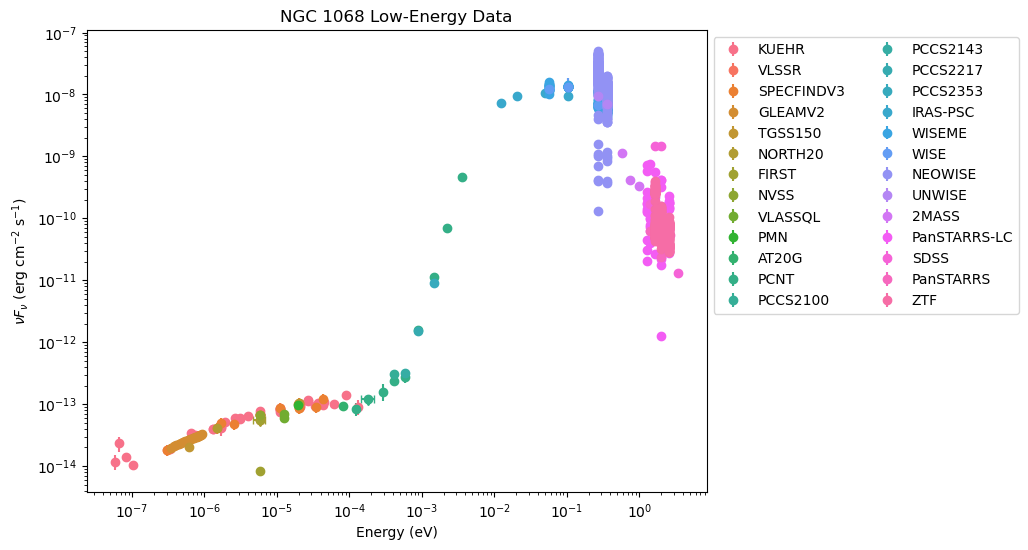

In [2]:
# Read the CSV file
df_low = pd.read_csv('NGC1068_low.csv')

# Use seaborn color palette for better legend colors
catalogs = df_low['catalog'].unique()
color_cycle = sns.color_palette("husl", n_colors=len(catalogs))

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_low[df_low['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    fraction = 0.2  # 20% of the flux, for example
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.title("NGC 1068 Low-Energy Data")
plt.show()

### SWIFT data own analysis

In [3]:
# Define column names for the unfolded spectrum
column_names = ['energy', 'denergy', 'flux', 'flux_err', 'model_flux']

# Read the QDP file, fixing the deprecation warning
df_unfolded = pd.read_table('mydata2.qdp', skiprows=3, names=column_names, sep='\s+')

# Replace 'NO' values with NaN and convert columns to numeric
df_unfolded.replace('NO', np.nan, inplace=True)
df_unfolded = df_unfolded.apply(pd.to_numeric)

In [4]:
# Identify the row with the largest error
idx_outlier = df_unfolded['flux_err'].idxmax()

# Drop that row from the DataFrame
df_plot = df_unfolded.drop(idx_outlier)

# Convert entire Series into Quantity objects before calling .to()
energy_Hz = df_plot['energy'].values * u.Hz
denergy_Hz = df_plot['denergy'].values * u.Hz

# Convert Hz -> eV
energy_eV = energy_Hz.to(u.eV, equivalencies=u.spectral())
denergy_eV = denergy_Hz.to(u.eV, equivalencies=u.spectral())

Text(0.5, 1.0, 'Unfolded XSPEC Spectrum of NGC 1068')

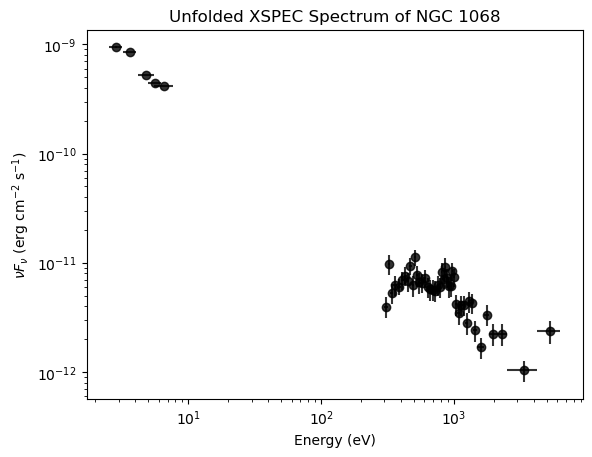

In [5]:
# Plot the unfolded XSPEC spectrum
plt.subplot()

plt.errorbar(
    energy_eV.value,
    df_plot['flux'],
    xerr=denergy_eV.value,
    yerr=df_plot['flux_err'],
    fmt='o',
    color='black',
    alpha=0.8
)

# Customize plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.title('Unfolded XSPEC Spectrum of NGC 1068')

### Gamma-ray data from Fermi catalogs

In [6]:
#Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()

source_fermi_4fgl = catalog_4fgl["4FGL J0242.6-0000"]
source_fermi_3fhl = catalog_3fhl["3FHL J0242.7-0002"]

dataset_4fgl = FluxPointsDataset(data=source_fermi_4fgl.flux_points, name="Fermi 4FGL-DR4")
dataset_4fgl.data.to_table(sed_type="dnde", formatted=True)

dataset_3fhl = FluxPointsDataset(data=source_fermi_3fhl.flux_points, name="Fermi 3FHL")
dataset_3fhl.data.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_errp,dnde_errn,dnde_ul,sqrt_ts,is_ul
GeV,GeV,GeV,1 / (GeV s cm2),1 / (GeV s cm2),1 / (GeV s cm2),1 / (GeV s cm2),,
float64,float64,float64,float64,float64,float64,float64,float32,bool
14.142,10.000,20.000,2.005e-12,1.080e-12,8.271e-13,nan,4.544,False
31.623,20.000,50.000,2.188e-13,1.925e-13,1.212e-13,nan,4.272,False
86.603,50.000,150.000,3.006e-19,4.080e-14,nan,8.159e-14,0.000,True
273.861,150.000,500.000,3.771e-23,1.122e-14,nan,2.243e-14,0.000,True
1000.000,500.000,2000.000,3.441e-23,2.432e-15,nan,4.865e-15,0.000,True


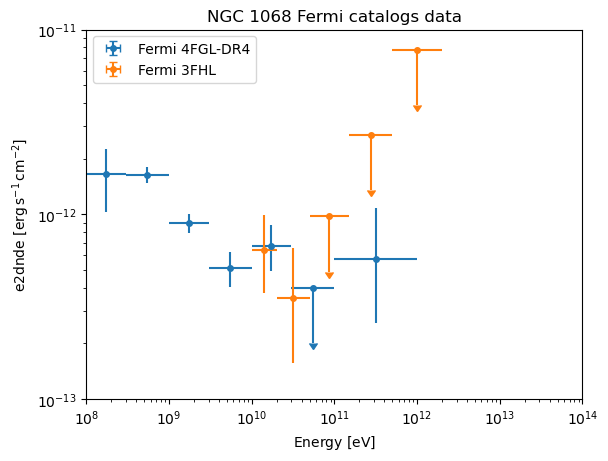

In [7]:
datasets = Datasets([dataset_4fgl, dataset_3fhl])

ax = plt.subplot()
ax.xaxis.set_units(u.Unit("eV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [0.0001, 100] * u.TeV 
ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
plt.title('NGC 1068 Fermi catalogs data')
ax.legend()
plt.show()

### Gamma-ray data from MAGIC

/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_40539/3246235203.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_ul = pd.read_csv('NGC1068_MAGIC_UL.dat', delim_whitespace=True, header=0)


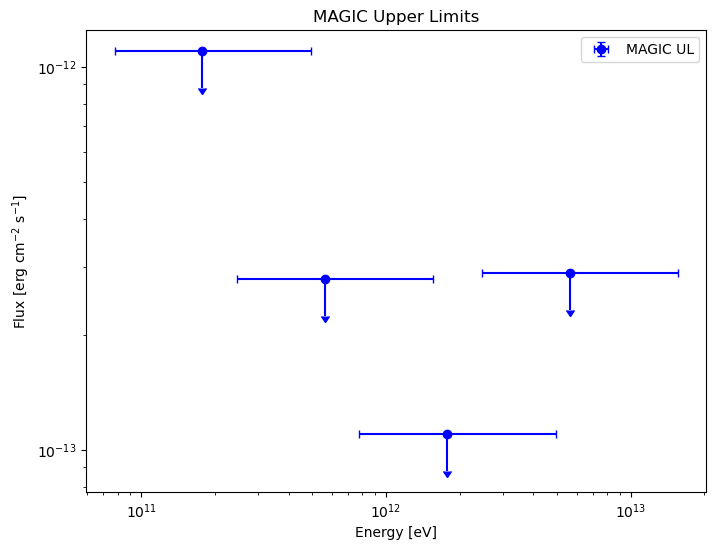

In [8]:
# Read the .dat file assuming whitespace-separated values.
df_ul = pd.read_csv('NGC1068_MAGIC_UL.dat', delim_whitespace=True, header=0)

# Rename columns for clarity
df_ul.columns = ['energy', 'energy_min', 'energy_max', 'flux_UL']

# Convert columns to numeric
df_ul['energy'] = pd.to_numeric(df_ul['energy'], errors='coerce')
df_ul['energy_min'] = pd.to_numeric(df_ul['energy_min'], errors='coerce')
df_ul['energy_max'] = pd.to_numeric(df_ul['energy_max'], errors='coerce')
df_ul['flux_UL'] = pd.to_numeric(df_ul['flux_UL'], errors='coerce')

# Convert MAGIC energy from GeV to eV (1 GeV = 1e9 eV)
df_ul['energy'] = df_ul['energy'] * 1e9
df_ul['energy_min'] = df_ul['energy_min'] * 1e9
df_ul['energy_max'] = df_ul['energy_max'] * 1e9

# We'll define a small fraction of the flux as the 'error' so that the arrow is visible.
fraction = 0.2  # 20% of the flux, for example

plt.figure(figsize=(8,6))

# Use uplims=True to draw a downward arrow from the data point
plt.errorbar(
    df_ul['energy'],
    df_ul['flux_UL'],
    yerr = fraction * df_ul['flux_UL'],
    xerr=[df_ul['energy_min'], df_ul['energy_max']],
    fmt='o',         # 'o' marker at the flux limit
    uplims=True,     # arrow indicates flux is only bounded from above
    color='blue',
    capsize=3,       # length of the error bar caps
    label='MAGIC UL'
)

plt.xlabel('Energy [eV]')
plt.ylabel('Flux [erg cm$^{-2}$ s$^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.title('MAGIC Upper Limits')
plt.legend()
plt.show()


## SED with own SWIFT data

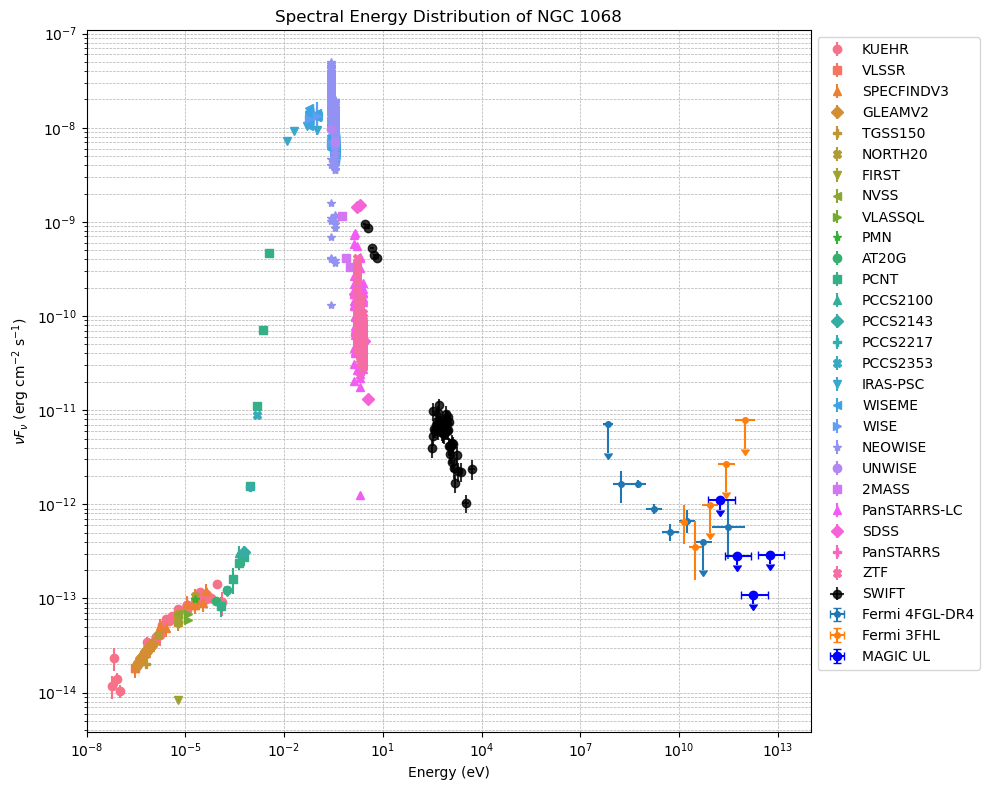

In [9]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Create a combined plot
fig, ax = plt.subplots(figsize=(10, 8))
# Set x-axis units to eV so that the Fermi plot (which uses eV) aligns correctly
ax.xaxis.set_units(u.Unit("eV"))

# Plot low-energy data (detections and upper limits)
for i, cat in enumerate(catalogs):
    df_cat = df_low[df_low['catalog'] == cat]
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections
    if not df_cat[det_mask].empty:
        ax.errorbar(df_cat.loc[det_mask, 'frequency'],
                    df_cat.loc[det_mask, 'flux'],
                    yerr=df_cat.loc[det_mask, 'flux_err'],
                    fmt=marker, color=color, label=f'{cat}')
    
    # Plot upper limits
    fraction = 0.2  # 20% of the flux, for example
    if not df_cat[ul_mask].empty:
        ax.errorbar(df_cat.loc[ul_mask, 'frequency'],
                    df_cat.loc[ul_mask, 'flux'],
                    yerr=df_cat.loc[ul_mask, 'flux_err'],
                    xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                    capsize=3,
                    fmt='o', color=color, uplims=True)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_plot['flux'],
            xerr=denergy_eV.value, yerr=df_plot['flux_err'],
            fmt='o', color='black', alpha=0.8, label='SWIFT')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(label=d.name, **kwargs)

# Plot MAGIC upper limits
# Use uplims=True to draw a downward arrow from the data point
plt.errorbar(
    df_ul['energy'],
    df_ul['flux_UL'],
    yerr=fraction * df_ul['flux_UL'],
    xerr=[df_ul['energy_min'], df_ul['energy_max']],
    fmt='o',         # 'o' marker at the flux limit
    uplims=True,     # arrow indicates flux is only bounded from above
    color='blue',
    capsize=3,       # length of the error bar caps
    label='MAGIC UL'
)

# Adjust axis limits to cover the full energy range
ax.set_xlim(1e-8, 1e14)

# Set labels and title
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
ax.set_title('Spectral Energy Distribution of NGC 1068')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.tight_layout()
plt.show()

## SED with own SWIFT data alongside archival data

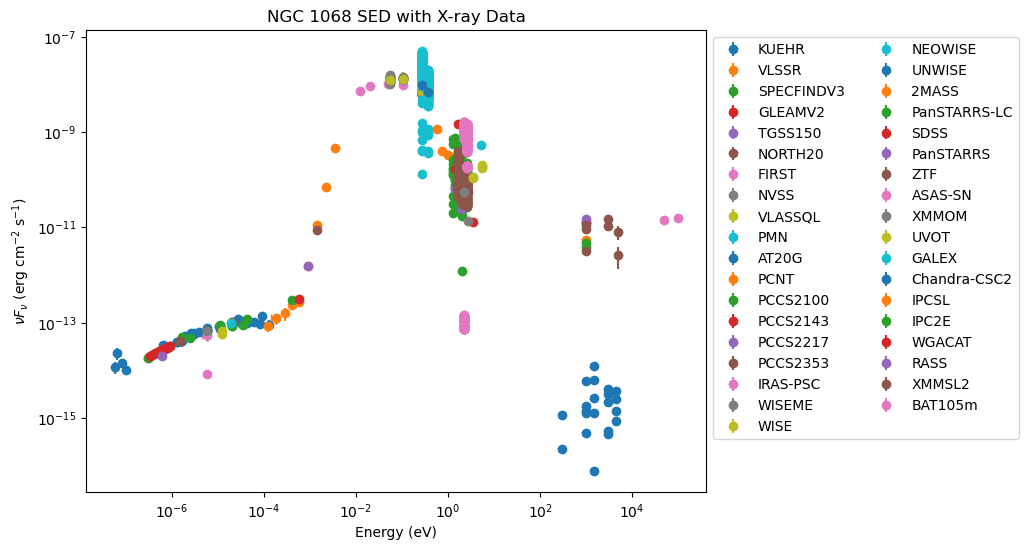

In [10]:
# Read the CSV file
df_x = pd.read_csv('NGC1068_xray.csv')


# Get a color cycle from matplotlib for distinct catalog colors
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get unique catalogs
catalogs = df_x['catalog'].unique()

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.title("NGC 1068 SED with X-ray Data")
plt.show()

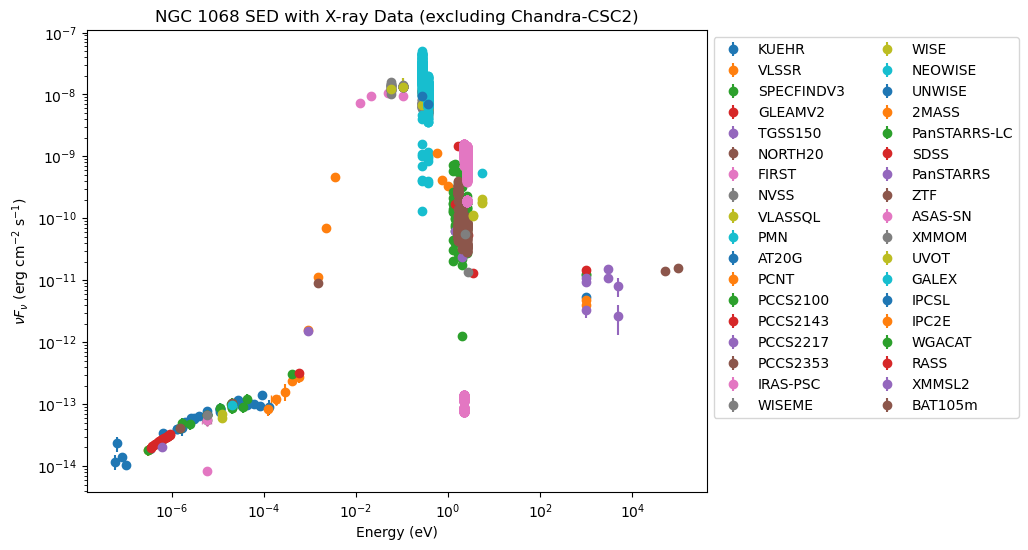

In [11]:
# Filter out rows where the catalog is 'Chandra-CSC2'
df_x = df_x[df_x['catalog'] != 'Chandra-CSC2']

# Get unique catalogs from the filtered DataFrame
catalogs = df_x['catalog'].unique()

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.title("NGC 1068 SED with X-ray Data (excluding Chandra-CSC2)")
plt.show()


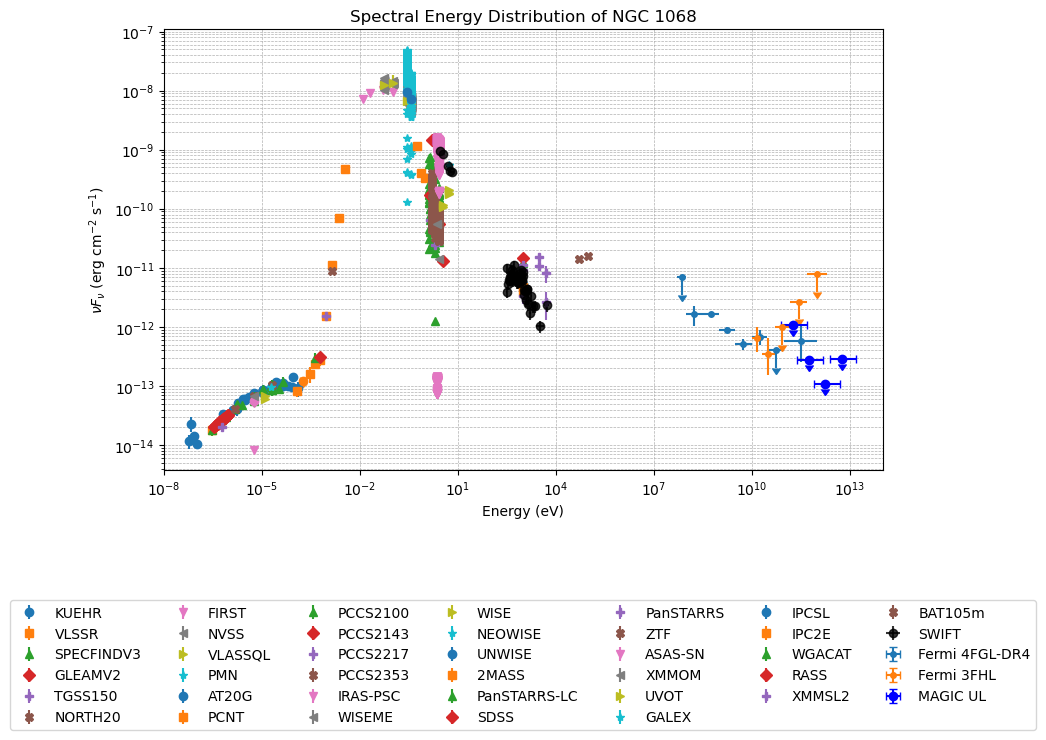

In [12]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Create a combined plot
fig, ax = plt.subplots(figsize=(10, 8))
# Set x-axis units to eV so that the Fermi plot (which uses eV) aligns correctly
ax.xaxis.set_units(u.Unit("eV"))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt=marker, color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_plot['flux'],
            xerr=denergy_eV.value, yerr=df_plot['flux_err'],
            fmt='o', color='black', alpha=0.8, label='SWIFT')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(label=d.name, **kwargs)

# Plot MAGIC upper limits
# Use uplims=True to draw a downward arrow from the data point
plt.errorbar(
    df_ul['energy'],
    df_ul['flux_UL'],
    yerr = fraction * df_ul['flux_UL'],
    xerr=[df_ul['energy_min'], df_ul['energy_max']],
    fmt='o',         # 'o' marker at the flux limit
    uplims=True,     # arrow indicates flux is only bounded from above
    color='blue',
    capsize=3,       # length of the error bar caps
    label='MAGIC UL'
)

# Adjust axis limits to cover the full energy range
ax.set_xlim(1e-8, 1e14)

# Set labels and title
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
ax.set_title('Spectral Energy Distribution of NGC 1068')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.28), ncol=7)

plt.tight_layout()
plt.show()

## SED with Neutrino Flux

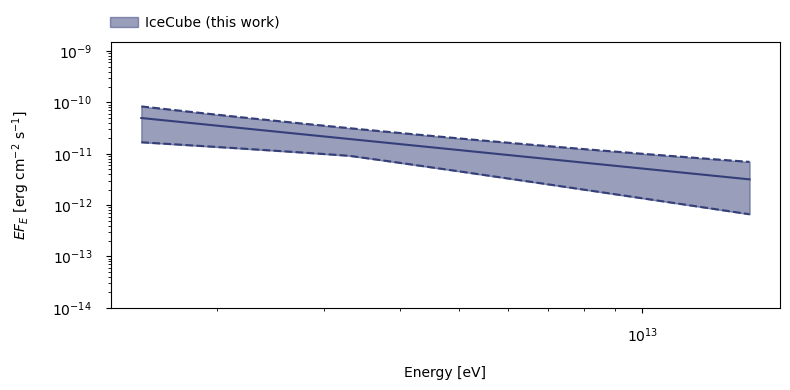

In [14]:
# Load NGC 1068 spectrum
(E_bins_GeV,
 best_fit_TeV,
 low_95_TeV,
 up_95_TeV) = np.genfromtxt('ngc1068_spectrum_95.txt', skip_header=1).T

# Convert Energy from GeV to eV
E_bins_eV = (E_bins_GeV * u.GeV).to(u.eV).value

# Convert flux from TeV cm^-2 s^-1 to erg cm^-2 s^-1
conversion_factor = (1 * u.TeV).to(u.erg).value
best_fit_erg = best_fit_TeV * conversion_factor
low_95_erg = low_95_TeV * conversion_factor
up_95_erg = up_95_TeV * conversion_factor

# Plot!
fig, ax = plt.subplots(figsize=(8,4))

# NGC 1068 spectrum
ngc1068_color = '#343E78'
ax.plot(E_bins_eV, low_95_erg, color=ngc1068_color, linestyle='--')
ax.plot(E_bins_eV, up_95_erg, color=ngc1068_color, linestyle='--')
ax.plot(E_bins_eV, best_fit_erg, color=ngc1068_color, linestyle='-')
ax.fill_between(E_bins_eV, low_95_erg, up_95_erg, color=ngc1068_color,
                alpha=0.5, label=r'IceCube (this work)')

# Axes settings
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-14, 1.5e-9)
ax.tick_params(axis='both', which='major', pad=10)
ax.set_xlabel('Energy [eV]', labelpad=15)
ax.set_ylabel(r'$E F_{E}$ [erg cm$^{-2}$ s$^{-1}$]', labelpad=15)

# Add legend
ax.legend(loc='lower left', frameon=False, handletextpad=0.5,
          bbox_to_anchor=(-0.02, 1.0), ncol=2, columnspacing=0.8)

plt.tight_layout()
plt.show()


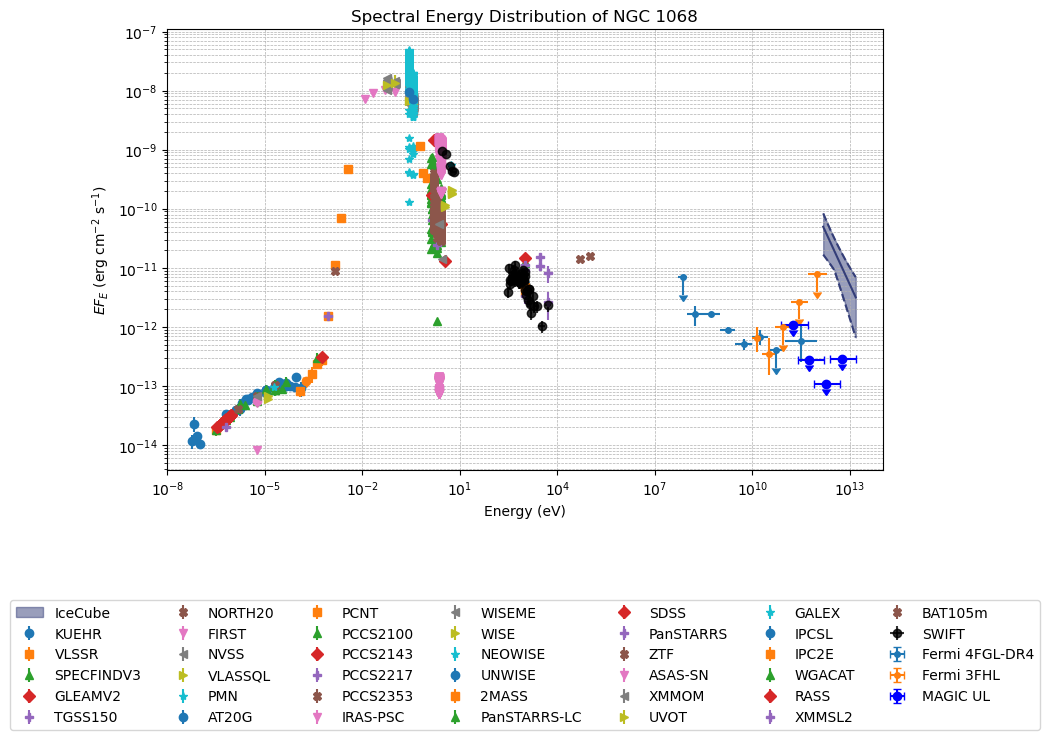

In [15]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Create a combined plot
fig, ax = plt.subplots(figsize=(10, 8))
# Set x-axis units to eV so that the Fermi plot (which uses eV) aligns correctly
ax.xaxis.set_units(u.Unit("eV"))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt=marker, color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_plot['flux'],
            xerr=denergy_eV.value, yerr=df_plot['flux_err'],
            fmt='o', color='black', alpha=0.8, label='SWIFT')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(label=d.name, **kwargs)

# Plot MAGIC upper limits
# Use uplims=True to draw a downward arrow from the data point
plt.errorbar(
    df_ul['energy'],
    df_ul['flux_UL'],
    yerr = fraction * df_ul['flux_UL'],
    xerr=[df_ul['energy_min'], df_ul['energy_max']],
    fmt='o',         # 'o' marker at the flux limit
    uplims=True,     # arrow indicates flux is only bounded from above
    color='blue',
    capsize=3,       # length of the error bar caps
    label='MAGIC UL'
)

# NGC 1068 spectrum
ngc1068_color = '#343E78'
ax.plot(E_bins_eV, low_95_erg, color=ngc1068_color, linestyle='--')
ax.plot(E_bins_eV, up_95_erg, color=ngc1068_color, linestyle='--')
ax.plot(E_bins_eV, best_fit_erg, color=ngc1068_color, linestyle='-')
ax.fill_between(E_bins_eV, low_95_erg, up_95_erg, color=ngc1068_color,
                alpha=0.5, label=r'IceCube')

# Adjust axis limits to cover the full energy range
ax.set_xlim(1e-8, 1e14)

# Set labels and title
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$E F_{E}$ (erg cm$^{-2}$ s$^{-1}$)')
ax.set_title('Spectral Energy Distribution of NGC 1068')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.28), ncol=7)

plt.tight_layout()
plt.show()

## Comparison SEDs

### Markarian Multiwavelength Data Center

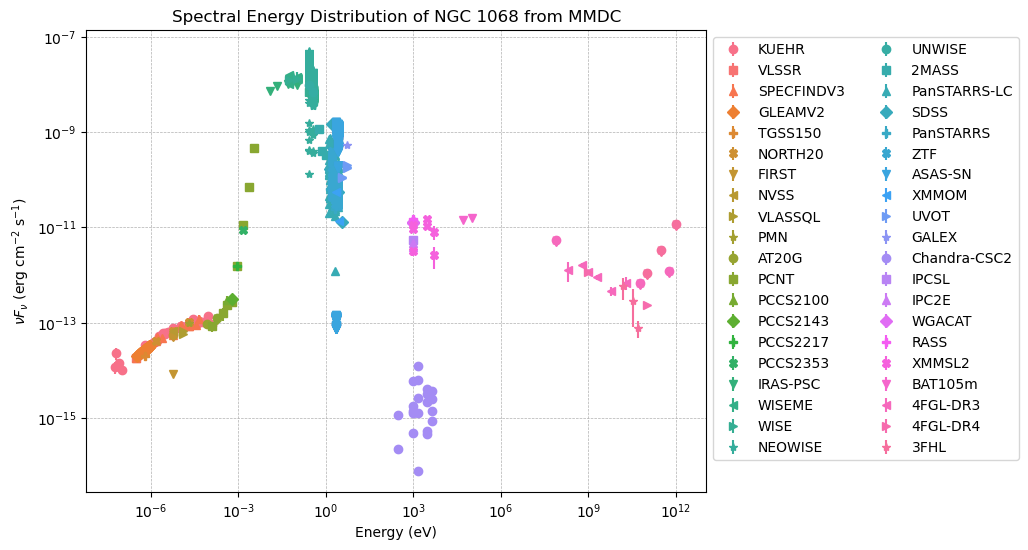

In [16]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Read the CSV file
df_low = pd.read_csv('NGC1068_complete.csv')

# Use seaborn color palette for better legend colors
catalogs = df_low['catalog'].unique()
color_cycle = sns.color_palette("husl", n_colors=len(catalogs))

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_low[df_low['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt=marker, color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    fraction = 0.2  # 20% of the flux, for example
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.title("Spectral Energy Distribution of NGC 1068 from MMDC")
plt.show()

### SED Builder

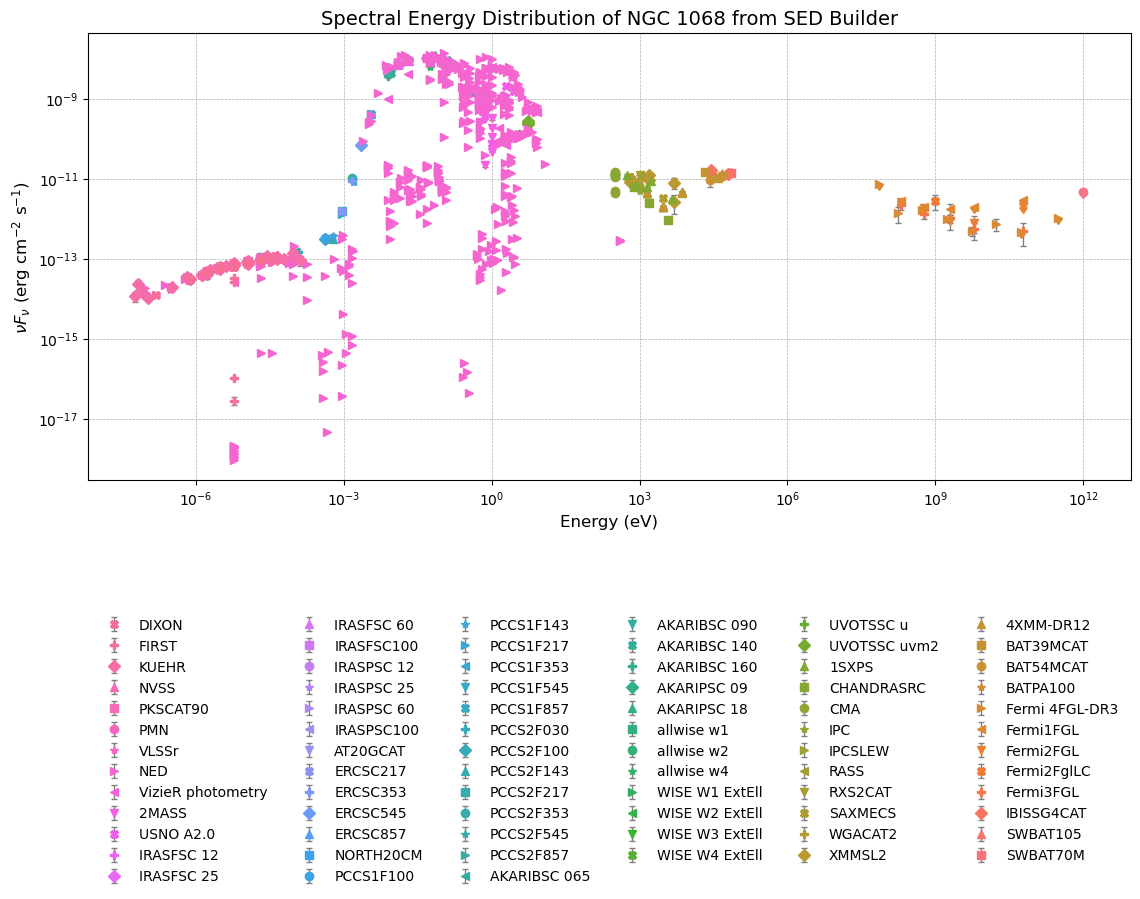

In [17]:
# Define marker styles and color palette
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']
palette = sns.color_palette("husl", 76)

# Load the data file
file_path = 'NGC1068_Builder.txt'

# Read the file and skip the header lines
with open(file_path, 'r') as f:
    lines = f.readlines()

# Data containers
data = []
upper_limit_data = []
dataset_labels = []
label_color_map = {}
label_marker_map = {}

current_label = None
color_index = 0
marker_index = 0

# Parse the file
for line in lines:
    if line.startswith('#'):
        if 'id' in line:
            current_label = line.split('(')[0].strip().replace('#', '').strip()
            if current_label not in dataset_labels:
                dataset_labels.append(current_label)
                label_color_map[current_label] = palette[color_index % len(palette)]
                label_marker_map[current_label] = markers[marker_index % len(markers)]
                color_index += 1
                marker_index += 1
        continue

    parts = line.split()
    if len(parts) >= 6:
        try:
            energy = float(parts[0])
            flux = float(parts[2])
            flux_error = float(parts[3])
            if 'UPPER LIMIT' in line:
                upper_limit_data.append([energy, flux, flux_error, current_label])
            else:
                data.append([energy, flux, flux_error, current_label])
        except ValueError:
            continue

# Convert to DataFrames
df = pd.DataFrame(data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])
upper_limit_df = pd.DataFrame(upper_limit_data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])

# Plotting
plt.figure(figsize=(12,10))

# Plot detections
for dataset in df['Dataset'].unique():
    subset = df[df['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 fmt=label_marker_map[dataset], label=dataset,
                 ecolor='gray', elinewidth=1, capsize=2,
                 color=label_color_map[dataset])

# Plot upper limits
for dataset in upper_limit_df['Dataset'].unique():
    subset = upper_limit_df[upper_limit_df['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 fmt=label_marker_map[dataset], uplims=True,
                 color=label_color_map[dataset], label=None)

# Axis settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (eV)', fontsize=12)
plt.ylabel(r'$\nu F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=12)
plt.title('Spectral Energy Distribution of NGC 1068 from SED Builder', fontsize=14)

# Legend settings
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper center',
           bbox_to_anchor=(0.5, -0.28), ncol=6, frameon=False)

plt.tight_layout()
plt.show()
